<a href="https://colab.research.google.com/github/ykato27/Algorithm-Test/blob/main/CenterTrack_Tracking_Objects_as_Points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CenterTrack - Tracking Objects as Points
Simultaneous object detection and tracking using center points:
<img src="https://github.com/xingyizhou/CenterTrack/raw/master/readme/fig2.png">

**Original code :** [CenterTrack](https://github.com/xingyizhou/CenterTrack) by [Xingyi Zhou](https://github.com/xingyizhou)

**[Tracking Objects as Points](http://arxiv.org/abs/2004.01177)**,

Xingyi Zhou, Vladlen Koltun, Philipp Krähenbühl,

*arXiv technical report [(arXiv 2004.01177)](http://arxiv.org/abs/2004.01177)*

**Citation**
```
@article{zhou2020tracking,
  title={Tracking Objects as Points},
  author={Zhou, Xingyi and Koltun, Vladlen and Kr{\"a}henb{\"u}hl, Philipp},
  journal={ECCV},
  year={2020}
}
```

In [1]:
! nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Wed Jul  7 13:10:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Installation
1. Install PyTorch:

In [2]:
import torch
print(torch.__version__)

1.4.0


In [3]:
! pip install torch==1.4.0 torchvision==0.5.0

2. Install [COCOAPI](https://github.com/cocodataset/cocoapi):

In [4]:
! pip install cython; pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-j4ra52fh
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-j4ra52fh
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263904 sha256=1cb34f5a43df2fb11e126725f86984a22fa9d49e8599b01be17ff3e40153b2cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-7gsmofko/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
ERROR: nuscenes-devkit 1.1.5 has requirement pycocotools>=2.0.1, but you'll have pycocotools 2.0 which is incompatible.
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


3. Clone this repo:

In [5]:
CenterTrack_ROOT="CenterTrack"
! git clone --recursive https://github.com/xingyizhou/CenterTrack $CenterTrack_ROOT
%cd CenterTrack

fatal: destination path 'CenterTrack' already exists and is not an empty directory.
/content/CenterTrack


You can manually install the [submodules](https://github.com/xingyizhou/CenterTrack/blob/master/.gitmodules) if you forget --recursive.

4. Install the requirements

In [6]:
! pip install -r requirements.txt
! apt-get install libx264-dev

Processing /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e/pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libx264-dev is already the newest version (2:0.152.2854+gite9a5903-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [7]:
%ls src/lib/model/networks/

backbones/     DCNv2/  dlav0.py            necks/        resdcn.py
base_model.py  dla.py  generic_network.py  __pycache__/  resnet.py


In [8]:
#%rm -r src/lib/model/networks/DCNv2

5. Compile deformable convolutional (from DCNv2).

In [9]:
# clone if it is not automatically downloaded by `--recursive`.
%%shell

cd src/lib/model/networks/
git clone https://github.com/CharlesShang/DCNv2/  
cd DCNv2/
./make.sh

fatal: destination path 'DCNv2' already exists and is not an empty directory.
running build
running build_ext
running develop
running egg_info
writing DCNv2.egg-info/PKG-INFO
writing dependency_links to DCNv2.egg-info/dependency_links.txt
writing top-level names to DCNv2.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'DCNv2.egg-info/SOURCES.txt'
running build_ext
copying build/lib.linux-x86_64-3.7/_ext.cpython-37m-x86_64-linux-gnu.so -> 
Creating /usr/local/lib/python3.7/dist-packages/DCNv2.egg-link (link to .)
DCNv2 0.1 is already the active version in easy-install.pth

Installed /content/CenterTrack/src/lib/model/networks/DCNv2
Processing dependencies for DCNv2==0.1
Finished processing dependencies for DCNv2==0.1


6. Download pertained models for [monocular 3D tracking](https://drive.google.com/open?id=1e8zR1m1QMJne-Tjp-2iY_o81hn2CiQRt), [80-category tracking](https://drive.google.com/open?id=1tJCEJmdtYIh8VuN8CClGNws3YO7QGd40), or [pose tracking](https://drive.google.com/open?id=1tJCEJmdtYIh8VuN8CClGNws3YO7QGd40) and move them to 
`$CenterTrack_ROOT/models/`. 

  More models can be found in [Model zoo](https://github.com/xingyizhou/CenterTrack/blob/master/readme/MODEL_ZOO.md).

In [10]:
%mkdir models
#! gdown --id 1e8zR1m1QMJne-Tjp-2iY_o81hn2CiQRt -O models/nuScenes_3Dtracking.pth
#! gdown --id 1tJCEJmdtYIh8VuN8CClGNws3YO7QGd40 -O models/coco_tracking.pth
#! gdown --id 1H0YvFYCOIZ06EzAkC2NxECNQGXxK27hH -O models/coco_pose_tracking.pth
! gdown --id 1sf1bWJ1LutwQ_wp176nd2Y3HII9WeFf0 -O models/mot17_half.pth
! gdown --id 1h_8Ts11rf0GQ4_n6FgmCeBuFcWrRjJfa -O models/mot17_fulltrain.pth

mkdir: cannot create directory ‘models’: File exists
Downloading...
From: https://drive.google.com/uc?id=1sf1bWJ1LutwQ_wp176nd2Y3HII9WeFf0
To: /content/CenterTrack/models/mot17_half.pth
80.0MB [00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h_8Ts11rf0GQ4_n6FgmCeBuFcWrRjJfa
To: /content/CenterTrack/models/mot17_fulltrain.pth
80.0MB [00:00, 155MB/s]


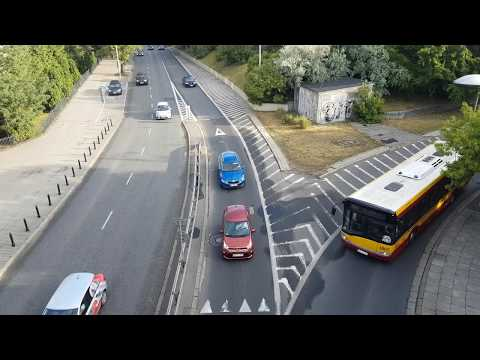

In [11]:
#!pip install youtube-dl
from IPython.display import YouTubeVideo

YOUTUBE_ID = 'MNn9qKG2UFI'   # car
#YOUTUBE_ID = 'MNn9qKG2UFI'   
#YOUTUBE_ID = '2bKXv_XviFc'    # pedestrian 

YouTubeVideo(YOUTUBE_ID)

In [12]:
#! rm -rf youtube.mp4
# download the youtube with the given ID
! youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube2.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
#! ffmpeg -y -loglevel info -i youtube2.mp4 -t 20 pedestrian.avi
! ffmpeg -y -loglevel info -i youtube.mp4 -t 20 road_traffic.mp4

/bin/bash: youtube-dl: command not found
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --ena

## Use CenterTrack

In [13]:
%cd src/

/content/CenterTrack/src


**Note:**
1. replace "cv2.imshow" in function show_all_image in "debugger.py(/src/lib/utils/)" with "pass"
2. comment out  "cv2.imshow" at line 80 in "demo.py".

Video clip from the [nuScenes dataset](https://www.nuscenes.org/?externalData=all&mapData=all&modalities=Any) in `videos/nuscenes_mini.mp4`. To test monocular 3D tracking on this video, run

In [14]:
! python demo.py tracking,ddd --load_model ../models/nuScenes_3Dtracking.pth --dataset nuscenes --pre_hm --track_thresh 0.1 --demo ../videos/nuscenes_mini.mp4 --test_focal_length 633 --save_video --video_h 480 --video_w 720 --debug 2
#! python demo.py tracking,ddd --load_model ../models/nuScenes_3Dtracking.pth --dataset nuscenes --pre_hm --track_thresh 0.1 --demo road_traffic.avi --save_video

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Running tracking
Using tracking threshold for out threshold! 0.1
Fix size testing.
training chunk_sizes: [32]
input h w: 448 800
heads {'hm': 10, 'reg': 2, 'wh': 2, 'tracking': 2, 'dep': 1, 'rot': 8, 'dim': 3, 'amodel_offset': 2}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1, 'dep': 1, 'rot': 1, 'dim': 1, 'amodel_offset': 1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256], 'dep': [256], 'rot': [256], 'dim': [256], 'amodel_offset': [256]}
Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
Traceback (most recent call last):
  File "demo.py", line 128, in <module>
    demo(opt)
  File "demo.py", line 24, in demo
    detector = Detector(opt)
  File "/conten

You will need to specify test_focal_length for monocular 3D tracking demo to convert the image coordinate system back to 3D. The value 633 is half of a typical focal length (~1266) in nuScenes dataset in input resolution 1600x900. The mini demo video is in an input resolution of 800x448, so we need to use a half focal length. You don't need to set the test_focal_length when testing on the original nuScenes data.

Similarly, for 80-category tracking on images/ video, run:

In [15]:
! python demo.py tracking --load_model ../models/coco_tracking.pth --demo road_traffic.mp4

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Running tracking
Using tracking threshold for out threshold! 0.3
Fix size testing.
training chunk_sizes: [32]
input h w: 512 512
heads {'hm': 80, 'reg': 2, 'wh': 2, 'tracking': 2}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256]}
Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
Traceback (most recent call last):
  File "demo.py", line 128, in <module>
    demo(opt)
  File "demo.py", line 24, in demo
    detector = Detector(opt)
  File "/content/CenterTrack/src/lib/detector.py", line 34, in __init__
    self.model = load_model(self.model, opt.load_model, opt)
  File "/content/CenterTrack/src/lib/model/model

If you want to test with person tracking models, you need to add --num_class 1:

In [16]:
! python demo.py tracking --load_model ../models/mot17_half.pth --num_class 1 --demo pedestrian.avi --save_video
#! python demo.py tracking --load_model ../models/mot17_fulltrain.pth --num_class 1 --demo pedestrian.avi --save_video --debug 2

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Running tracking
Using tracking threshold for out threshold! 0.3
Fix size testing.
training chunk_sizes: [32]
input h w: 512 512
heads {'hm': 1, 'reg': 2, 'wh': 2, 'tracking': 2}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256]}
Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
loaded ../models/mot17_half.pth, epoch 70
Drop parameter ltrb_amodal.0.weight.
Drop parameter ltrb_amodal.0.bias.
Drop parameter ltrb_amodal.2.weight.
Drop parameter ltrb_amodal.2.bias.
Drop parameter base.pre_hm_layer.0.weight.
Drop parameter base.pre_hm_layer.1.weight.
Drop parameter base.pre_hm_layer.1.bias.
Drop parameter base.pr

You can add --debug 2 to visualize the heatmap and offset predictions.

In [17]:
! python demo.py tracking --load_model ../models/mot17_half.pth --num_class 1 --debug 2 --demo video.mp4

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Running tracking
Using tracking threshold for out threshold! 0.3
Fix size testing.
training chunk_sizes: [32]
input h w: 512 512
heads {'hm': 1, 'reg': 2, 'wh': 2, 'tracking': 2}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256]}
Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
loaded ../models/mot17_half.pth, epoch 70
Drop parameter ltrb_amodal.0.weight.
Drop parameter ltrb_amodal.0.bias.
Drop parameter ltrb_amodal.2.weight.
Drop parameter ltrb_amodal.2.bias.
Drop parameter base.pre_hm_layer.0.weight.
Drop parameter base.pre_hm_layer.1.weight.
Drop parameter base.pre_hm_layer.1.bias.
Drop parameter base.pr

For monocular 3D tracking, run

In [18]:
! python demo.py tracking,ddd --demo ../road_traffic.mp4 --load_model ../models/coco_tracking.pth --save_video

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Running tracking
Using tracking threshold for out threshold! 0.3
Fix size testing.
training chunk_sizes: [32]
input h w: 448 800
heads {'hm': 10, 'reg': 2, 'wh': 2, 'tracking': 2, 'dep': 1, 'rot': 8, 'dim': 3, 'amodel_offset': 2}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1, 'dep': 1, 'rot': 1, 'dim': 1, 'amodel_offset': 1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256], 'dep': [256], 'rot': [256], 'dim': [256], 'amodel_offset': [256]}
Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
Traceback (most recent call last):
  File "demo.py", line 128, in <module>
    demo(opt)
  File "demo.py", line 24, in demo
    detector = Detector(opt)
  File "/conten

Similarly, for pose tracking, run:

In [19]:
! python demo.py tracking,multi_pose --load_model ../models/coco_pose.pth --demo video.mp4

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Running tracking
Using tracking threshold for out threshold! 0.3
Fix size testing.
training chunk_sizes: [32]
input h w: 512 512
heads {'hm': 1, 'reg': 2, 'wh': 2, 'tracking': 2, 'hps': 34, 'hm_hp': 17, 'hp_offset': 2}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1, 'hps': 1, 'hm_hp': 1, 'hp_offset': 1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256], 'hps': [256], 'hm_hp': [256], 'hp_offset': [256]}
Creating model...
Using node type: (<class 'model.networks.dla.DeformConv'>, <class 'model.networks.dla.DeformConv'>)
Traceback (most recent call last):
  File "demo.py", line 128, in <module>
    demo(opt)
  File "demo.py", line 24, in demo
    detector = Detector(opt)
  File "/content/CenterTrack/src/lib/detector.py", lin

## Training on custom dataset
If you want to train CenterTrack on your own dataset, you can use `--dataset custom` and manually specify the annotation file, image path, input resolutions, and number of categories. You still need to create the annotation files in COCO format (referring to the many `convert_X_to_coco.py` examples in tools). For example, you can use the following command to train on our [mot17 experiment](https://github.com/xingyizhou/CenterTrack/blob/master/experiments/mot17_half_sc.sh) without using the pre-defined mot dataset file:

In [20]:
! python main.py tracking --exp_id mot17_half_sc --dataset custom --custom_dataset_ann_path ../data/mot17/annotations/train_half.json --custom_dataset_img_path ../data/mot17/train/ --input_h 544 --input_w 960 --num_classes 1 --pre_hm --ltrb_amodal --same_aug --hm_disturb 0.05 --lost_disturb 0.4 --fp_disturb 0.1 --gpus 0

Running tracking
Using tracking threshold for out threshold! 0.3
Fix size testing.
training chunk_sizes: [32]
input h w: 544 960
heads {'hm': 1, 'reg': 2, 'wh': 2, 'tracking': 2, 'ltrb_amodal': 4}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1, 'ltrb_amodal': 0.1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256], 'ltrb_amodal': [256]}
Namespace(K=100, add_05=False, amodel_offset_weight=1, arch='dla_34', aug_rot=0, backbone='dla34', batch_size=32, chunk_sizes=[32], custom_dataset_ann_path='../data/mot17/annotations/train_half.json', custom_dataset_img_path='../data/mot17/train/', data_dir='/content/CenterTrack/src/lib/../../data', dataset='custom', dataset_version='', debug=0, debug_dir='/content/CenterTrack/src/lib/../../exp/tracking/mot17_half_sc/debug', debugger_theme='white', demo='', dense_reg=1, dep_weight=1, depth_scale=1, dim_weight=1, dla_node='dcn', down_ratio=4, efficient_level=0, eval_val=False, exp_dir='/content/CenterTrack/src/lib/../../exp/tracki

## Benchmark Evaluation and Training
After installation, follow the instructions in [DATA.md](https://github.com/xingyizhou/CenterTrack/blob/master/readme/DATA.md) to setup the datasets. Then check [GETTING_STARTED.md](https://github.com/xingyizhou/CenterTrack/blob/master/readme/GETTING_STARTED.md) to reproduce the results in the paper. We provide scripts for all the experiments in the [experiments folder](https://github.com/xingyizhou/CenterTrack/blob/master/experiments).

### **Benchmark evaluation**
First, download the models you want to evaluate from our model zoo and put them in CenterTrack_ROOT/models/.

**MOT17**

To test the tracking performance on MOT17 with our pretrained model, run

In [21]:
! python test.py tracking --exp_id mot17_half --dataset mot --dataset_version 17halfval --pre_hm --ltrb_amodal --track_thresh 0.4 --pre_thresh 0.5 --load_model ../models/mot17_half.pth

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Running tracking
Using tracking threshold for out threshold! 0.4
Fix size testing.
training chunk_sizes: [32]
input h w: 544 960
heads {'hm': 1, 'reg': 2, 'wh': 2, 'tracking': 2, 'ltrb_amodal': 4}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1, 'ltrb_amodal': 0.1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256], 'ltrb_amodal': [256]}
Namespace(K=100, add_05=False, amodel_offset_weight=1, arch='dla_34', aug_rot=0, backbone='dla34', batch_size=32, chunk_sizes=[32], custom_dataset_ann_path='', custom_dataset_img_path='', data_dir='/content/CenterTrack/src/lib/../../data', dataset='mot', dataset_version='17halfval', debug=0, debug_dir='/content/CenterTrack/src/lib/../../exp/tracking/mot17_half/debug', debugger_theme='white'

This will give a MOTA of `66.1` if set up correctly. `--pre_hm` is to enable the input heatmap. `--ltrb_amodal` is to use the left, top, right, bottom bounding box representation to enable detecting out-of-image bounding box (We observed this is important for MOT datasets). And `--track_thresh` and `--pre_thresh` are the score threshold for predicting a bounding box ($\theta$ in the paper) and feeding the heatmap to the next frame ($\tau$ in the paper), respectively.

To test with public detection, run

In [22]:
! python test.py tracking --exp_id mot17_half_public --dataset mot --dataset_version 17halfval --pre_hm --ltrb_amodal --track_thresh 0.4 --pre_thresh 0.5 --load_model ../models/mot17_half.pth --public_det --load_results ../data/mot17/results/val_half_det.json

/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
Running tracking
Using tracking threshold for out threshold! 0.4
Fix size testing.
training chunk_sizes: [32]
input h w: 544 960
heads {'hm': 1, 'reg': 2, 'wh': 2, 'tracking': 2, 'ltrb_amodal': 4}
weights {'hm': 1, 'reg': 1, 'wh': 0.1, 'tracking': 1, 'ltrb_amodal': 0.1}
head conv {'hm': [256], 'reg': [256], 'wh': [256], 'tracking': [256], 'ltrb_amodal': [256]}
Namespace(K=100, add_05=False, amodel_offset_weight=1, arch='dla_34', aug_rot=0, backbone='dla34', batch_size=32, chunk_sizes=[32], custom_dataset_ann_path='', custom_dataset_img_path='', data_dir='/content/CenterTrack/src/lib/../../data', dataset='mot', dataset_version='17halfval', debug=0, debug_dir='/content/CenterTrack/src/lib/../../exp/tracking/mot17_half_public/debug', debugger_theme=

The expected MOTA is `63.1`.

To test on the test set, run

### Training
We have packed all the training scripts in the [experiments folder](https://github.com/xingyizhou/CenterTrack/blob/master/experiments). The experiment names correspond to the model name in the [model zoo](https://github.com/xingyizhou/CenterTrack/blob/master/experiments). The number of GPUs for each experiment can be found in the scripts and the model zoo. If the training is terminated before finishing, you can use the same command with `--resume` to resume training. It will found the latest model with the same `exp_id`. Some experiments rely on pretraining on another model. In this case, download the pretrained model from our model zoo or train that model first.